In [15]:
import sys
from pathlib import Path

# Move from notebooks/ → project root
PROJECT_ROOT = Path.cwd().parent

# Add src/models to sys.path so Python can find baseline_cnn.py
sys.path.insert(0, str(PROJECT_ROOT / "src" / "model"))

# Now you can import the class
from baseline_cnn import BaselineCNN

print("BaselineCNN class import successful")


BaselineCNN class import successful


In [16]:
import torch
from baseline_cnn import BaselineCNN
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
MODEL_PATH = PROJECT_ROOT / "models" / "baseline_cnn.pth"

# Reconstruct the architecture
model = BaselineCNN(
    n_mels=64,
    num_classes=6
)

# Load the checkpoint dictionary
checkpoint = torch.load(MODEL_PATH, map_location="cpu")

# Extract only the model_state_dict
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()

print("BaselineCNN loaded with weights from checkpoint")


BaselineCNN loaded with weights from checkpoint


In [19]:
# Loading a test audio
import librosa
import torch
import numpy as np
from pathlib import Path

DATA_DIR = PROJECT_ROOT / "data" / "raw" / "CommonVoice"
AUDIO_PATH = DATA_DIR / "indian_accent" / "indian_accent_0.wav"

y, sr = librosa.load(AUDIO_PATH, sr=16000)  # resample to 16kHz
print(f"Audio shape: {y.shape}, Sampling rate: {sr}")


Audio shape: (160000,), Sampling rate: 16000


In [21]:
# convert the logmel spectogram to match crema-d
n_mels = 64
n_fft = 1024
hop_length = 512

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
log_mel = librosa.power_to_db(mel, ref=np.max)

print(f"Log-mel shape: {log_mel.shape}")


Log-mel shape: (64, 313)


In [22]:
# Prepare Tensor for the model
x = torch.tensor(log_mel).unsqueeze(0).unsqueeze(0).float()  # (1, 1, n_mels, time)
print(f"Tensor shape for CNN: {x.shape}")


Tensor shape for CNN: torch.Size([1, 1, 64, 313])


In [23]:
# test model
with torch.no_grad():
    logits = model(x)

print(f"Logits shape: {logits.shape}")
print(f"Logits: {logits}")


Logits shape: torch.Size([1, 6])
Logits: tensor([[  81.1962,  -11.5147,   46.1006,   17.5169, -108.8245,  -86.8268]])


In [24]:
# test more files
for accent in ["british_accent", "american_accent"]:
    audio_file = list((DATA_DIR / accent).glob("*.wav"))[0]
    y, sr = librosa.load(audio_file, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    x = torch.tensor(log_mel).unsqueeze(0).unsqueeze(0).float()
    with torch.no_grad():
        logits = model(x)
    print(f"{accent} logits: {logits}")


british_accent logits: tensor([[ 104.9166,  -17.7782,   40.7587,   18.7443, -120.8275, -111.1603]])
american_accent logits: tensor([[  94.4068,  -16.3417,   32.3718,   16.3362, -103.8033, -100.7215]])


In [26]:
import pandas as pd
from pathlib import Path
import os

# Path to your Common Voice dataset
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "CommonVoice"

# Accents available
accents = ["indian_accent", "british_accent", "american_accent"]

rows = []

for accent in accents:
    accent_dir = DATA_DIR / accent
    for fname in sorted(os.listdir(accent_dir)):
        if fname.endswith(".wav"):
            rows.append({
                "file_path": f"{accent}/{fname}",  # relative path from DATA_DIR
                "accent": accent.replace("_accent", "")
            })

# Create DataFrame
df = pd.DataFrame(rows)

# Save metadata.csv inside your dataset folder
METADATA_PATH = DATA_DIR / "metadata.csv"
df.to_csv(METADATA_PATH, index=False)

print(f"Metadata.csv created at {METADATA_PATH}")
print(df.head())


Metadata.csv created at /Users/pc/Desktop/CODING/Others/fairvoice/data/raw/CommonVoice/metadata.csv
                            file_path  accent
0   indian_accent/indian_accent_0.wav  indian
1   indian_accent/indian_accent_1.wav  indian
2  indian_accent/indian_accent_10.wav  indian
3  indian_accent/indian_accent_11.wav  indian
4  indian_accent/indian_accent_12.wav  indian


In [29]:
import sys
from pathlib import Path
import pandas as pd
import torch
import librosa
import numpy as np

# Set project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "commonvoice"
METADATA_PATH = DATA_DIR / "metadata.csv"
MODEL_PATH = PROJECT_ROOT / "models" / "baseline_cnn.pth"

# Add src/models to Python path for import
sys.path.insert(0, str(PROJECT_ROOT / "src" / "models"))
from baseline_cnn import BaselineCNN

# Load metadata
df = pd.read_csv(METADATA_PATH)
print(f"Loaded {len(df)} files")
print(df.head())

# Initialize model
device = torch.device("cpu")
model = BaselineCNN(n_mels=64, num_classes=6)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Parameters for log-mel
n_mels = 64
n_fft = 1024
hop_length = 512
MIN_FRAMES = 32

# Function to preprocess audio with padding for short clips
def preprocess_audio(file_path, min_frames=MIN_FRAMES):
    y, sr = librosa.load(DATA_DIR / file_path, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    if log_mel.shape[1] < min_frames:
        pad_width = min_frames - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0,0),(0,pad_width)), mode='constant')
    x = torch.tensor(log_mel).unsqueeze(0).unsqueeze(0).float()
    return x

# Run inference on all files and collect metrics
results = []
for idx, row in df.iterrows():
    try:
        x = preprocess_audio(row['file_path'])
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            confidence = probs.max().item()
            entropy = -(probs * torch.log(probs + 1e-8)).sum().item()
            predicted_class = probs.argmax().item()
        results.append({
            "file_path": row['file_path'],
            "accent": row['accent'],
            "predicted_class": predicted_class,
            "confidence": confidence,
            "entropy": entropy
        })
    except Exception as e:
        print(f"Skipping {row['file_path']} due to error: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"Processed {len(results_df)} files successfully")

# Aggregate metrics per accent
accent_metrics = results_df.groupby("accent").agg(
    mean_confidence=("confidence", "mean"),
    mean_entropy=("entropy", "mean")
).reset_index()

print("Per-accent metrics:")
print(accent_metrics)

# Save results
results_df.to_csv(DATA_DIR / "accent_predictions.csv", index=False)
accent_metrics.to_csv(DATA_DIR / "accent_metrics.csv", index=False)


Loaded 197 files
                            file_path  accent
0   indian_accent/indian_accent_0.wav  indian
1   indian_accent/indian_accent_1.wav  indian
2  indian_accent/indian_accent_10.wav  indian
3  indian_accent/indian_accent_11.wav  indian
4  indian_accent/indian_accent_12.wav  indian


/Users/pc/opt/anaconda3/envs/tensorflow_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=0
  warnings.warn(


Processed 197 files successfully
Per-accent metrics:
     accent  mean_confidence  mean_entropy
0  american         1.000000  3.389337e-15
1   british         1.000000  1.741978e-16
2    indian         0.990302  2.804739e-02


Skipping indian_accent/indian_accent_7.wav due to error: Empty audio
Skipping indian_accent/indian_accent_9.wav due to error: Empty audio
Processed 195 files successfully
Balanced metrics per accent:
     accent  mean_confidence  mean_entropy
0  american         1.000000  3.389337e-15
1   british         1.000000  6.305082e-18
2    indian         0.999994  5.978606e-05


/var/folders/hf/bsqs2lc125d29dp41sngv3xc0000gn/T/ipykernel_8835/264948698.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_results = results_df.groupby("accent").apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


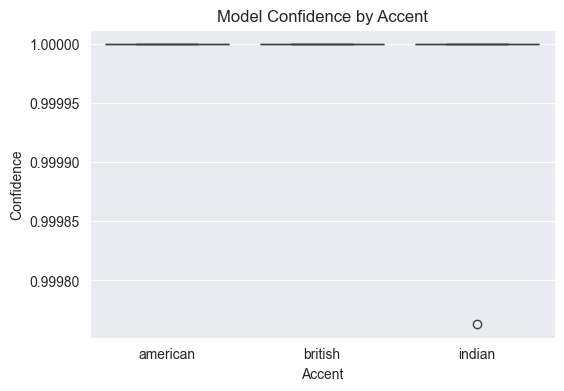

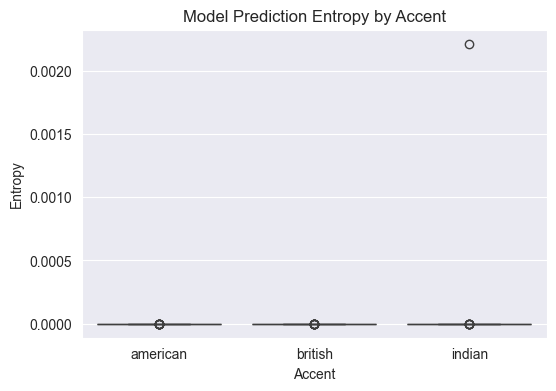

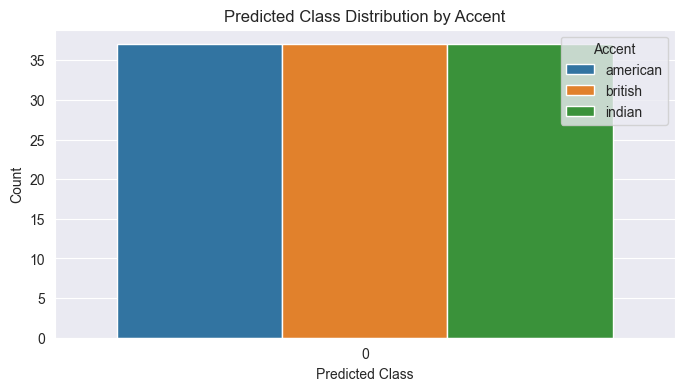

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "commonvoice"
METADATA_PATH = DATA_DIR / "metadata.csv"
MODEL_PATH = PROJECT_ROOT / "models" / "baseline_cnn.pth"

# Add src/models to path for import
sys.path.insert(0, str(PROJECT_ROOT / "src" / "models"))
from baseline_cnn import BaselineCNN

# Load metadata
df = pd.read_csv(METADATA_PATH)

# Initialize model
device = torch.device("cpu")
model = BaselineCNN(n_mels=64, num_classes=6)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Log-mel parameters
n_mels = 64
n_fft = 1024
hop_length = 512
MIN_FRAMES = 32

# Audio preprocessing with padding
def preprocess_audio(file_path, min_frames=MIN_FRAMES):
    y, sr = librosa.load(DATA_DIR / file_path, sr=16000)
    if len(y) == 0:
        raise ValueError("Empty audio")
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    if log_mel.shape[1] < min_frames:
        pad_width = min_frames - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0,0),(0,pad_width)), mode='constant')
    x = torch.tensor(log_mel).unsqueeze(0).unsqueeze(0).float()
    return x

# Run inference on all files
results = []
for idx, row in df.iterrows():
    try:
        x = preprocess_audio(row['file_path'])
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            confidence = probs.max().item()
            entropy = -(probs * torch.log(probs + 1e-8)).sum().item()
            predicted_class = probs.argmax().item()
        results.append({
            "file_path": row['file_path'],
            "accent": row['accent'],
            "predicted_class": predicted_class,
            "confidence": confidence,
            "entropy": entropy
        })
    except Exception as e:
        print(f"Skipping {row['file_path']} due to error: {e}")

results_df = pd.DataFrame(results)
print(f"Processed {len(results_df)} files successfully")

# Downsample accents to the same number of samples (smallest group)
min_count = results_df['accent'].value_counts().min()
balanced_results = results_df.groupby("accent").apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Aggregate metrics per accent
accent_metrics_balanced = balanced_results.groupby("accent").agg(
    mean_confidence=("confidence", "mean"),
    mean_entropy=("entropy", "mean")
).reset_index()

print("Balanced metrics per accent:")
print(accent_metrics_balanced)

# Save CSVs for report
results_df.to_csv(DATA_DIR / "accent_predictions_full.csv", index=False)
balanced_results.to_csv(DATA_DIR / "accent_predictions_balanced.csv", index=False)
accent_metrics_balanced.to_csv(DATA_DIR / "accent_metrics_balanced.csv", index=False)

# Plot confidence per accent
plt.figure(figsize=(6,4))
sns.boxplot(data=balanced_results, x="accent", y="confidence")
plt.title("Model Confidence by Accent")
plt.ylabel("Confidence")
plt.xlabel("Accent")
plt.savefig(DATA_DIR / "confidence_by_accent.png")
plt.show()

# Plot entropy per accent
plt.figure(figsize=(6,4))
sns.boxplot(data=balanced_results, x="accent", y="entropy")
plt.title("Model Prediction Entropy by Accent")
plt.ylabel("Entropy")
plt.xlabel("Accent")
plt.savefig(DATA_DIR / "entropy_by_accent.png")
plt.show()

# Optional: plot predicted class distribution per accent
plt.figure(figsize=(8,4))
sns.countplot(data=balanced_results, x="predicted_class", hue="accent")
plt.title("Predicted Class Distribution by Accent")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.legend(title="Accent")
plt.savefig(DATA_DIR / "predicted_class_distribution.png")
plt.show()


#### Per-class analysis per accent

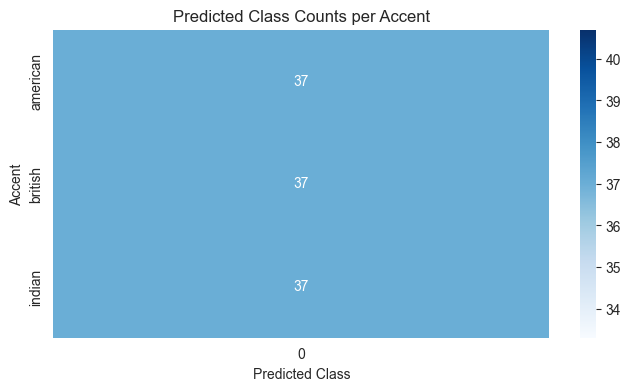

In [32]:


# Use the balanced results for fair comparison
df = balanced_results.copy()

# Count predicted classes per accent
class_counts = df.groupby(['accent', 'predicted_class']).size().reset_index(name='count')

# Pivot for heatmap (accent vs predicted class)
heatmap_data = class_counts.pivot(index='accent', columns='predicted_class', values='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='Blues')
plt.title('Predicted Class Counts per Accent')
plt.ylabel('Accent')
plt.xlabel('Predicted Class')
plt.savefig(DATA_DIR / "predicted_class_heatmap.png")
plt.show()


#### Statistical metrics

In [33]:
from scipy.stats import kruskal

# Use the balanced results
df = balanced_results.copy()

# Group confidence and entropy by accent
groups_conf = [group["confidence"].values for name, group in df.groupby("accent")]
groups_entropy = [group["entropy"].values for name, group in df.groupby("accent")]

# Kruskal-Wallis test for confidence
stat_conf, p_conf = kruskal(*groups_conf)
print(f"Kruskal-Wallis test for confidence: H={stat_conf:.3f}, p={p_conf:.4f}")

# Kruskal-Wallis test for entropy
stat_entropy, p_entropy = kruskal(*groups_entropy)
print(f"Kruskal-Wallis test for entropy: H={stat_entropy:.3f}, p={p_entropy:.4f}")


Kruskal-Wallis test for confidence: H=2.000, p=0.3679
Kruskal-Wallis test for entropy: H=34.218, p=0.0000


#### Visualizations

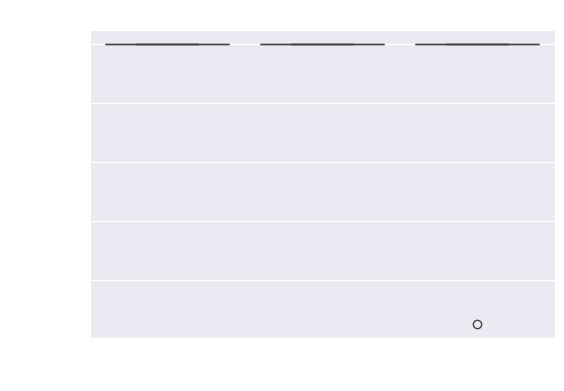

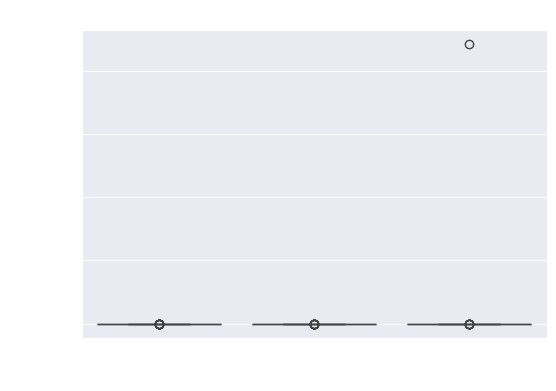

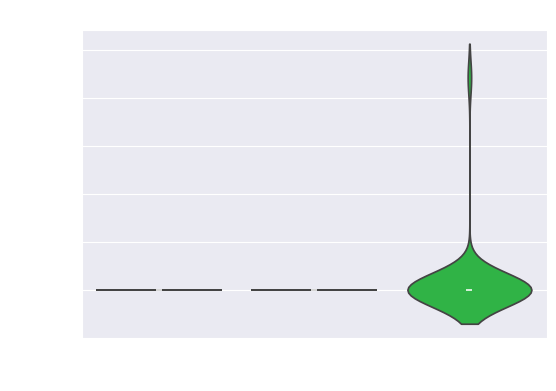

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

df = balanced_results.copy()

# Boxplot of confidence per accent (bright colors, no legend)
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="accent", y="confidence", hue="accent", dodge=False, palette="bright", legend=False)
plt.title("Model Confidence by Accent", color='white')
plt.ylabel("Confidence", color='white')
plt.xlabel("Accent", color='white')
plt.tick_params(colors='white')
plt.legend_.remove() if plt.gca().get_legend() else None
plt.savefig(DATA_DIR / "confidence_by_accent_bright.png", facecolor='black')
plt.show()

# Boxplot of entropy per accent
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="accent", y="entropy", hue="accent", dodge=False, palette="bright", legend=False)
plt.title("Prediction Entropy by Accent", color='white')
plt.ylabel("Entropy", color='white')
plt.xlabel("Accent", color='white')
plt.tick_params(colors='white')
plt.legend_.remove() if plt.gca().get_legend() else None
plt.savefig(DATA_DIR / "entropy_by_accent_bright.png", facecolor='black')
plt.show()

# Violin plot for entropy distribution
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="accent", y="entropy", hue="accent", dodge=False, palette="bright", legend=False)
plt.title("Prediction Entropy Distribution by Accent", color='white')
plt.ylabel("Entropy", color='white')
plt.xlabel("Accent", color='white')
plt.tick_params(colors='white')
plt.legend_.remove() if plt.gca().get_legend() else None
plt.savefig(DATA_DIR / "entropy_violin_by_accent_bright.png", facecolor='black')
plt.show()


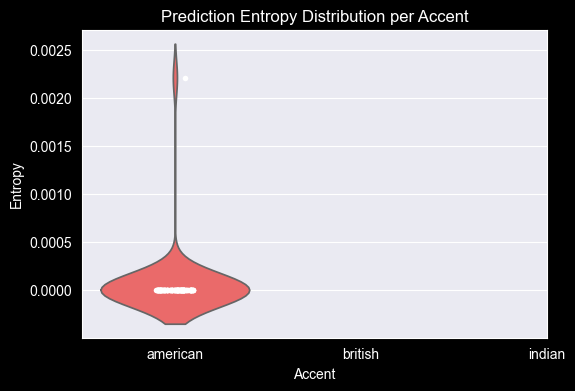

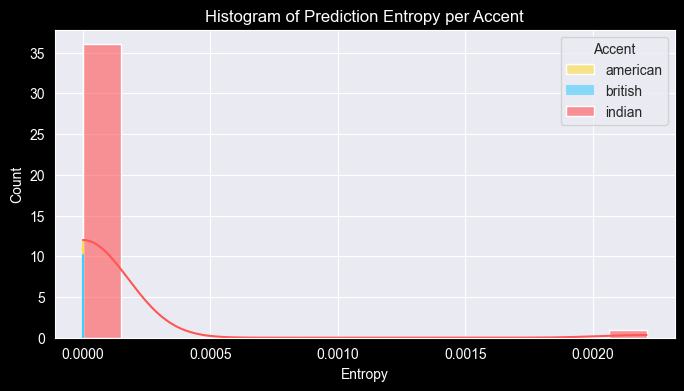

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

df = balanced_results.copy()
accents = df['accent'].unique()
colors = ["#FFDD44", "#44CCFF", "#FF5555"]  # bright colors for dark mode

# Violin plot with manual colors
plt.figure(figsize=(6,4))
for i, accent in enumerate(accents):
    sns.violinplot(
        data=df[df['accent']==accent],
        x=[""]*len(df[df['accent']==accent]),  # dummy x for single group
        y="entropy",
        color=colors[i],
        inner=None
    )
    # Overlay data points
    sns.stripplot(
        data=df[df['accent']==accent],
        x=[""]*len(df[df['accent']==accent]),
        y="entropy",
        color='white',
        size=4,
        jitter=True
    )

plt.xticks(ticks=range(len(accents)), labels=accents, color='white')
plt.title("Prediction Entropy Distribution per Accent", color='white')
plt.ylabel("Entropy", color='white')
plt.xlabel("Accent", color='white')
plt.tick_params(colors='white')
plt.gcf().patch.set_facecolor('black')
plt.savefig(DATA_DIR / "entropy_violin_points_bright.png", facecolor='black')
plt.show()

# Histogram of entropy per accent
plt.figure(figsize=(8,4))
for i, accent in enumerate(accents):
    sns.histplot(
        df[df['accent']==accent]['entropy'],
        kde=True,
        color=colors[i],
        label=accent,
        bins=15,
        alpha=0.6
    )

plt.title("Histogram of Prediction Entropy per Accent", color='white')
plt.xlabel("Entropy", color='white')
plt.ylabel("Count", color='white')
plt.legend(title="Accent")
plt.tick_params(colors='white')
plt.gcf().patch.set_facecolor('black')
plt.savefig(DATA_DIR / "entropy_histogram_bright.png", facecolor='black')
plt.show()


In [44]:
DATA_DIR

PosixPath('/Users/pc/Desktop/CODING/Others/fairvoice/data/raw/commonvoice')